In [95]:
import json
import pickle
from collections import Counter
import os
import editdistance
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn import set_config

import matplotlib.pyplot as plt

set_config(display="diagram")

In [109]:
#1. Retrieve Data from the Datasets (Accounts, Posts and Labels)
accounts_json = json.load(open('../data/bots/cresci-rtbust-2019_tweets.json'))
accounts = {
    account['user']['id']: account['user']
    for account in accounts_json
}
account_ids = accounts.keys()

labels = {
    int(line.strip().split('\t')[0]): 1 if line.strip().split('\t')[1] == 'bot' else 0
    for line in open('../data/bots/cresci-rtbust-2019.tsv')
}

timelines = pickle.load(open('../data/bots/account_timeline.pkl', 'rb'))

len(accounts)

693

In [110]:
#2. Feature Extraction

accounts_df = pd.DataFrame()

# 2a. Features from the Account information

accounts_df['name_length'] = [len(accounts[acc_id]['name']) for acc_id in account_ids] # Username Length
accounts_df['screen_name_length'] = [len(accounts[acc_id]['screen_name']) for acc_id in account_ids] # Display Name Length
accounts_df['distance_name_screename'] = [editdistance.eval(accounts[acc_id]['name'], accounts[acc_id]['screen_name']) for acc_id in account_ids] # Levenshtein Distance
accounts_df['has_location'] = [int(len(accounts[acc_id]['location']) > 0) for acc_id in account_ids] # Has a Location?
accounts_df['has_description'] = [int(len(accounts[acc_id]['description']) > 0) for acc_id in account_ids] # Has a Profile Description?
accounts_df['age'] = [2019 - datetime.strptime(accounts[acc_id]['created_at'],'%a %b %d %H:%M:%S %z %Y').year for acc_id in account_ids] # Account age
accounts_df['#_follow'] = [accounts[acc_id]['followers_count'] for acc_id in account_ids] # Follower Count
accounts_df['#_friend'] = [accounts[acc_id]['friends_count'] for acc_id in account_ids] # Friends Count
accounts_df['ratio_follow_friend'] = [accounts[acc_id]['followers_count'] / (accounts[acc_id]['friends_count'] + 1) for acc_id in account_ids] # Followers/Friends Ratio
accounts_df['freq_favorite'] = [
    accounts[acc_id]['favourites_count'] / (2019 - datetime.strptime(accounts[acc_id]['created_at'],'%a %b %d %H:%M:%S %z %Y').year)
    for acc_id in account_ids
] # Favourite posts count / profile age
accounts_df['freq_production'] = [
    accounts[acc_id]['statuses_count'] / (2019 - datetime.strptime(accounts[acc_id]['created_at'],'%a %b %d %H:%M:%S %z %Y').year)
    for acc_id in account_ids
] # Published posts count / profile age

# 2b. Feature from the Timeline information

def doc_from_content(tweets):
    """Returns a string concatenating the hashtags extracted from the tweets."""
    hashtags = []
    for tweet in tweets:
        for hashtag_obj in tweet.get('entities',{}).get('hashtags',[]):
            hashtags.append(hashtag_obj['tag'])
    return ' '.join(hashtags)

def text_from_content(tweets):
    """Returns a string concatenating the contents of the tweets."""
    user_document = ' '.join([tweet['text'] for tweet in tweets])
    return user_document

accounts_df['hashtags'] = [doc_from_content(timelines.get(str(acc_id), [])) for acc_id in account_ids] # Account Hashtags
accounts_df['text'] = [text_from_content(timelines.get(str(acc_id), [])) for acc_id in account_ids] # Account contents

# 2c. The Label

accounts_df['label'] = [labels[acc_id] for acc_id in account_ids]


In [111]:
accounts_df

,name_length,screen_name_length,distance_name_screename,has_location,has_description,age,#_follow,#_friend,ratio_follow_friend,freq_favorite,freq_production,hashtags,text,label
0,9,8,1,0,0,4,218,285,0.762238,576.250000,869.250000,ilcantantemascherato icmangelo BuongiornoCanta...,RT @milly_carlucci: Un personaggio tutto da sc...,1
1,39,15,32,1,1,3,256,358,0.713092,2520.333333,1871.333333,10YearsOf1D 10YearsOf1D TheLPShow TheLPShow Th...,RT @NiallOfficial: @sweetIikestyles Please don...,1
2,13,10,8,1,1,2,287,346,0.827089,3221.500000,2772.500000,edicola 21agosto M5S Salvini G7Biarritz G7Biar...,RT @spinax64: L’ennesimo capolavoro di quelli ...,0
3,5,9,4,0,0,4,266,354,0.749296,300.500000,1505.500000,Dieci Dieci Dieci 5ottobre2018 x newalbum vale...,"RT @AllMusicItalia: Ecco svelate copertina, tr...",1
4,11,11,2,0,1,2,286,564,0.506195,1255.500000,1957.500000,SCANUALLEIENE SCANUALLEIENE SCANUALLEIENE SCAN...,Quanto dobbiamo ancora attendere ? @Valerio_Sc...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,14,7,12,0,0,4,152,46,3.234043,250.500000,533.500000,repost CanYaman CanYaman CANYAMAN tbt repost C...,RT @Stefani29974118: #repost canyamanmaniaoffi...,1
689,10,10,2,0,1,2,301,863,0.348380,273.000000,1969.000000,SCANUALLEIENE SCANUALLEIENE SCANUALLEIENE iocr...,"Eccomi, io non potevo mancare... aspetto solam...",1
690,15,15,0,0,0,3,35,33,1.029412,2317.666667,2286.000000,,,1
691,5,11,10,1,1,3,134,155,0.858974,4543.666667,4146.333333,DietroFestival michelebravi DietroFestival San...,"RT @michele_bravi: Inverno dei fiori, un scamb...",0


In [112]:
# 3. Data Preprocessing

# 3a. Remove rows where hashtags are ''
accounts_df = accounts_df[accounts_df['hashtags'] != '']

# 3b. Remove the labels, we'll need them later
labels_col = accounts_df.pop('label')

# 3c. Preparing the ColumnTransformer
dataframe_ct = ColumnTransformer([
        ('numerical_minmax', MinMaxScaler(), ['age','distance_name_screename']),
        ('numerical_standard', StandardScaler(), ['name_length','screen_name_length','ratio_follow_friend']),
        ('numerical_change_distro', PowerTransformer(), ['freq_favorite','freq_production','#_follow','#_friend']),
        ('drop', 'drop', ['hashtags', 'text'])
    ],
    remainder='passthrough'
)


In [113]:
accounts_df

,name_length,screen_name_length,distance_name_screename,has_location,has_description,age,#_follow,#_friend,ratio_follow_friend,freq_favorite,freq_production,hashtags,text
0,9,8,1,0,0,4,218,285,0.762238,576.250000,869.250000,ilcantantemascherato icmangelo BuongiornoCanta...,RT @milly_carlucci: Un personaggio tutto da sc...
1,39,15,32,1,1,3,256,358,0.713092,2520.333333,1871.333333,10YearsOf1D 10YearsOf1D TheLPShow TheLPShow Th...,RT @NiallOfficial: @sweetIikestyles Please don...
2,13,10,8,1,1,2,287,346,0.827089,3221.500000,2772.500000,edicola 21agosto M5S Salvini G7Biarritz G7Biar...,RT @spinax64: L’ennesimo capolavoro di quelli ...
3,5,9,4,0,0,4,266,354,0.749296,300.500000,1505.500000,Dieci Dieci Dieci 5ottobre2018 x newalbum vale...,"RT @AllMusicItalia: Ecco svelate copertina, tr..."
4,11,11,2,0,1,2,286,564,0.506195,1255.500000,1957.500000,SCANUALLEIENE SCANUALLEIENE SCANUALLEIENE SCAN...,Quanto dobbiamo ancora attendere ? @Valerio_Sc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,4,12,8,0,0,3,240,536,0.446927,4698.666667,7826.666667,OggièUnAltroGiorno 19aprile UnaVocePerSanMarin...,RT @altrogiornorai1: ☀️☀️☀️Nel Sole ☀️☀️☀️\n@V...
688,14,7,12,0,0,4,152,46,3.234043,250.500000,533.500000,repost CanYaman CanYaman CANYAMAN tbt repost C...,RT @Stefani29974118: #repost canyamanmaniaoffi...
689,10,10,2,0,1,2,301,863,0.348380,273.000000,1969.000000,SCANUALLEIENE SCANUALLEIENE SCANUALLEIENE iocr...,"Eccomi, io non potevo mancare... aspetto solam..."
691,5,11,10,1,1,3,134,155,0.858974,4543.666667,4146.333333,DietroFestival michelebravi DietroFestival San...,"RT @michele_bravi: Inverno dei fiori, un scamb..."


In [127]:
# 4. Training

# 4a. Dataset Splitting
X_train, X_test, y_train, y_test = train_test_split(
    accounts_df,
    labels_col,
    test_size=0.2, # 20% of the Dataset goes to the Test Set
    stratify=labels_col, # This ensures that the split sets have a similar distribution of labels
    random_state=42
)

print(np.sum(y_train == 0) / np.sum(y_train == 1), np.sum(y_test == 0) / np.sum(y_test == 1))

# 4b. Build the Pipeline
bot_detector = Pipeline([
    ('preprocesing', dataframe_ct),
    ('classifier', LogisticRegression(penalty=None)),
])

bot_detector.fit(X_train, y_train)

0.9539748953974896 0.95


C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_minmax',
                                                  MinMaxScaler(),
                                                  ['age',
                                                   'distance_name_screename']),
                                                 ('numerical_standard',
                                                  StandardScaler(),
                                                  ['name_length',
                                                   'screen_name_length',
                                                   'ratio_follow_friend']),
                                                 ('numerical_change_distro',
                                                  PowerTransformer(),
                                                  ['freq_favorite',
                                                   'freq_production',
                                                   '#_follow', '#_friend']),
                                                 ('drop', 'drop',
                                                  ['hashtags', 'text'])])),
                ('classifier', LogisticRegression(penalty=None))])

In [128]:
# 5. Prediction

y_predicted = bot_detector.predict(X_test)

y_predicted[:10]

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

Accuracy:
0.7863247863247863 0.8029978586723768
Recall:
0.7833333333333333 0.7866108786610879
F1 Score:
0.7899159663865546 0.8034188034188035


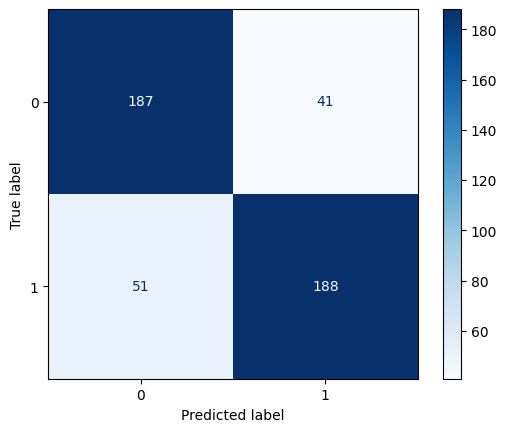

In [132]:
# 6. Valutazione della Performance

y_train_predicted = bot_detector.predict(X_train)
y_test_predicted = bot_detector.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_predicted, cmap=plt.cm.Blues)

print("Accuracy:")
print(accuracy_score(y_test, y_test_predicted), accuracy_score(y_train, y_train_predicted))

print("Recall:")
print(recall_score(y_test, y_test_predicted), recall_score(y_train, y_train_predicted))

print("F1 Score:")
print(f1_score(y_test, y_test_predicted), f1_score(y_train, y_train_predicted))

# ROC and AuROC ...